# Data Science- Doc2Vec

### Ignore plotting warnings

In [75]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### Import packages

In [76]:
from collections import Counter
from sklearn import metrics

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Metrics function

* Generic function for calculating the number of class ratios
* Precision, Recall, F1
* Accuracy 

In [77]:
def model_metrics(Train_Y, Test_Y, predictions):
    print('===================================\n')
    print("Train target values count: ", Counter(Train_Y))
    print("Test target values count: ", Counter(Test_Y))
    print("Result values count: ", Counter(predictions))
    print('\n', metrics.classification_report(Test_Y, predictions))
    print("Accuracy Score: ",accuracy_score(predictions, Test_Y)*100)


## Import data

* Data wrangling
* Includes oversampling and undersampling for managing unbalanced classes

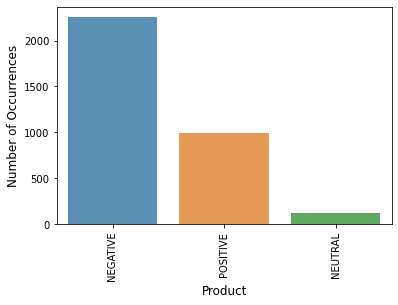

In [78]:

np.random.seed(42)

path = 'portal_articles_positivity_class.csv'

data = pd.read_csv(path)
data = data.dropna(subset = ['Title_positivity_sentence', 'Subtitle_positivity_sentence', 'Text_positivity_sentence'])

class_count_df = data['Positivity'].value_counts()

sns.barplot(class_count_df.index, class_count_df.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();


### Dataset balancing

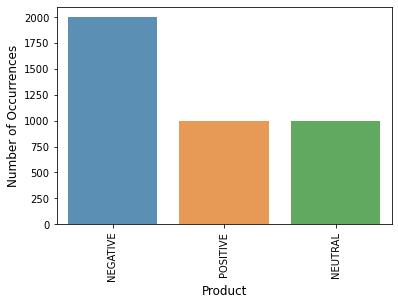

In [79]:


data_positive = data[data['Positivity'] == 'POSITIVE']
data_neutral = data[data['Positivity'] == 'NEUTRAL']
data_negative = data[data['Positivity'] == 'NEGATIVE']
#N!: 2256 P: 993 N: 121

# Downsample majority class
data_negative_downsampled = resample(data_negative, 
                                 replace=False,    # sample without replacement
                                 n_samples=2000,     # to match minority class   993?
                                 random_state=42) # reproducible results

# Upsample minority class
data_neutral_upsampled = resample(data_neutral, 
                                 replace=True,     # sample with replacement
                                 n_samples=993,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
data = pd.concat([data_negative_downsampled, data_positive, data_neutral_upsampled])

class_count_df = data['Positivity'].value_counts()

sns.barplot(class_count_df.index, class_count_df.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();





## Training and testing split

In [80]:
import nltk

train, test = train_test_split(data, test_size=0.3, stratify=data['Positivity'], random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Article_text']), tags=[r.Positivity]), axis=1)

test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Article_text']), tags=[r.Positivity]), axis=1)



In [81]:
import multiprocessing

cores = multiprocessing.cpu_count()


## Buidling a vocabulary

In [82]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 2790/2790 [00:00<00:00, 2786216.23it/s]


## Training doc2vec model

In [83]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 2790/2790 [00:00<?, ?it/s]
Wall time: 21.9 s


In [84]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

## Training the Classifier

In [85]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = RandomForestClassifier(n_estimators=200, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

model_metrics(y_train, y_test, y_pred)

Testing accuracy 0.49498327759197325
Testing F1 score: 0.42424020222652953

Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 695, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 298, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 970, 'POSITIVE': 121, 'NEUTRAL': 105})

               precision    recall  f1-score   support

    NEGATIVE       0.53      0.85      0.65       600
     NEUTRAL       0.38      0.13      0.20       298
    POSITIVE       0.33      0.13      0.19       298

    accuracy                           0.49      1196
   macro avg       0.41      0.37      0.35      1196
weighted avg       0.44      0.49      0.42      1196

Accuracy Score:  49.49832775919732


In [86]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 2790/2790 [00:00<00:00, 1398435.49it/s]


In [87]:
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 2790/2790 [00:00<00:00, 699008.91it/s]


In [88]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


model_metrics(y_train, y_test, y_pred)


Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 695, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 298, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 794, 'POSITIVE': 209, 'NEUTRAL': 193})

               precision    recall  f1-score   support

    NEGATIVE       0.55      0.73      0.63       600
     NEUTRAL       0.42      0.28      0.33       298
    POSITIVE       0.46      0.32      0.38       298

    accuracy                           0.51      1196
   macro avg       0.48      0.44      0.45      1196
weighted avg       0.50      0.51      0.49      1196

Accuracy Score:  51.33779264214047


In [89]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [90]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [91]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

model_metrics(y_train, y_test, y_pred)


Train target values count:  Counter({'NEGATIVE': 1400, 'POSITIVE': 695, 'NEUTRAL': 695})
Test target values count:  Counter({'NEGATIVE': 600, 'POSITIVE': 298, 'NEUTRAL': 298})
Result values count:  Counter({'NEGATIVE': 969, 'NEUTRAL': 165, 'POSITIVE': 62})

               precision    recall  f1-score   support

    NEGATIVE       0.54      0.87      0.67       600
     NEUTRAL       0.33      0.18      0.24       298
    POSITIVE       0.18      0.04      0.06       298

    accuracy                           0.49      1196
   macro avg       0.35      0.36      0.32      1196
weighted avg       0.40      0.49      0.41      1196

Accuracy Score:  49.163879598662206
